# Multi-Modal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Author(s)
Add your information here

Name(s): Ali Goodarzi | Usama Raheel

Student number(s): 2307234 | 2410692

## Description 

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as 
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals 

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material 

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br> 
<p> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>

</div>

In [1]:
# Import relevant libraries here
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd

# Enter data folder location
loc = "./MEx"

In [2]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""
def path_to_meta(p):
    meta = dict()
    meta["subject_id"] = p.parent.stem
    meta["exercise_id"] = p.stem.split("_")[-2]
    meta["trial"] = int(p.stem.split("_")[-1])
    meta["sensor_code"] = p.stem.split("_")[0]
    meta["sensor"] = {"act": "acc", "dc": "dc"}[meta["sensor_code"]]
    return meta

# Find, read, and compose the measurements
paths_record = Path(loc).glob("*/*/*.csv")

records = []

for path_record in paths_record:
    df = pd.read_csv(path_record, delimiter=",", header=None)
    meta = path_to_meta(path_record)
    
    if meta["sensor"] == "acc":
        col_names = ["time", "acc_0", "acc_1", "acc_2"]
        df.columns = col_names
    else:
        num_cols = df.shape[1]
        col_names = ["time", ] + [f"dc_{i}" for i in range(num_cols-1)]
        df.columns = col_names

    meta["df"] = df
    
    records.append(meta)

df_records = pd.DataFrame.from_records(records)

print(f"Total records found: {len(df_records)}")
print("Dataframe with all records:")
display(df_records.head())
print("Dataframe with one measurement series:")
display(df_records["df"].iloc[0].head())

Total records found: 160
Dataframe with all records:


,subject_id,exercise_id,trial,sensor_code,sensor,df
0,01,01,1,act,acc,time acc_0 acc_1 acc_2 0 ...
1,01,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...
2,01,03,1,act,acc,time acc_0 acc_1 acc_2 0 ...
3,01,04,1,act,acc,time acc_0 acc_1 acc_2 0 ...
4,01,04,2,act,acc,time acc_0 acc_1 acc_2 0 ...


Dataframe with one measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.515625,-0.843750,-0.131944
1,10.0,-0.515625,-0.853125,-0.134375
2,20.0,-0.515625,-0.850000,-0.140625
3,30.0,-0.515625,-0.862500,-0.150000
4,40.0,-0.525000,-0.856250,-0.156250


In [3]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""

# Extract 5-second long windows with 2-second shift (3-second overlap)

records_windowed = []

time_window = 5000.
time_offset = 2000.
    
for row_idx, row_data in df_records.iterrows():
    df_tmp = row_data["df"]
    time_start = np.min(df_tmp["time"].to_numpy())
    time_end = np.max(df_tmp["time"].to_numpy())
    
    for window_idx, t0 in enumerate(np.arange(time_start, time_end, time_offset)):
        t1 = t0 + time_window
        # Handle boundary conditions - skip the measurements from the end shorter than window size
        if t1 > time_end:
            continue
        
        tmp_data = deepcopy(row_data)
        tmp_data["window_idx"] = window_idx
        tmp_data["df"] = df_tmp[(df_tmp["time"] >= t0) &
                                (df_tmp["time"] < t1)].copy()
        
        records_windowed.append(tmp_data)
        
df_records_windowed = pd.DataFrame.from_records(records_windowed)

print(f"Total windows extracted: {len(df_records_windowed)}")
print("Dataframe with all windowed records:")
display(df_records_windowed.head())
print("Dataframe with one windowed measurement series:")
display(df_records_windowed["df"].iloc[0].head())
print(df_records_windowed.shape)

Total windows extracted: 4169
Dataframe with all windowed records:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,01,01,1,act,acc,time acc_0 acc_1 acc_2 0 ...,0
1,01,01,1,act,acc,time acc_0 acc_1 acc_2 200 ...,1
2,01,01,1,act,acc,time acc_0 acc_1 acc_2 400 ...,2
3,01,01,1,act,acc,time acc_0 acc_1 acc_2 60...,3
4,01,01,1,act,acc,time acc_0 acc_1 acc_2 80...,4


Dataframe with one windowed measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.515625,-0.843750,-0.131944
1,10.0,-0.515625,-0.853125,-0.134375
2,20.0,-0.515625,-0.850000,-0.140625
3,30.0,-0.515625,-0.862500,-0.150000
4,40.0,-0.525000,-0.856250,-0.156250


(4169, 7)


<a id='task1'></a>
<div class=" alert alert-warning">
     
<p> <b>1.1</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>

</div>

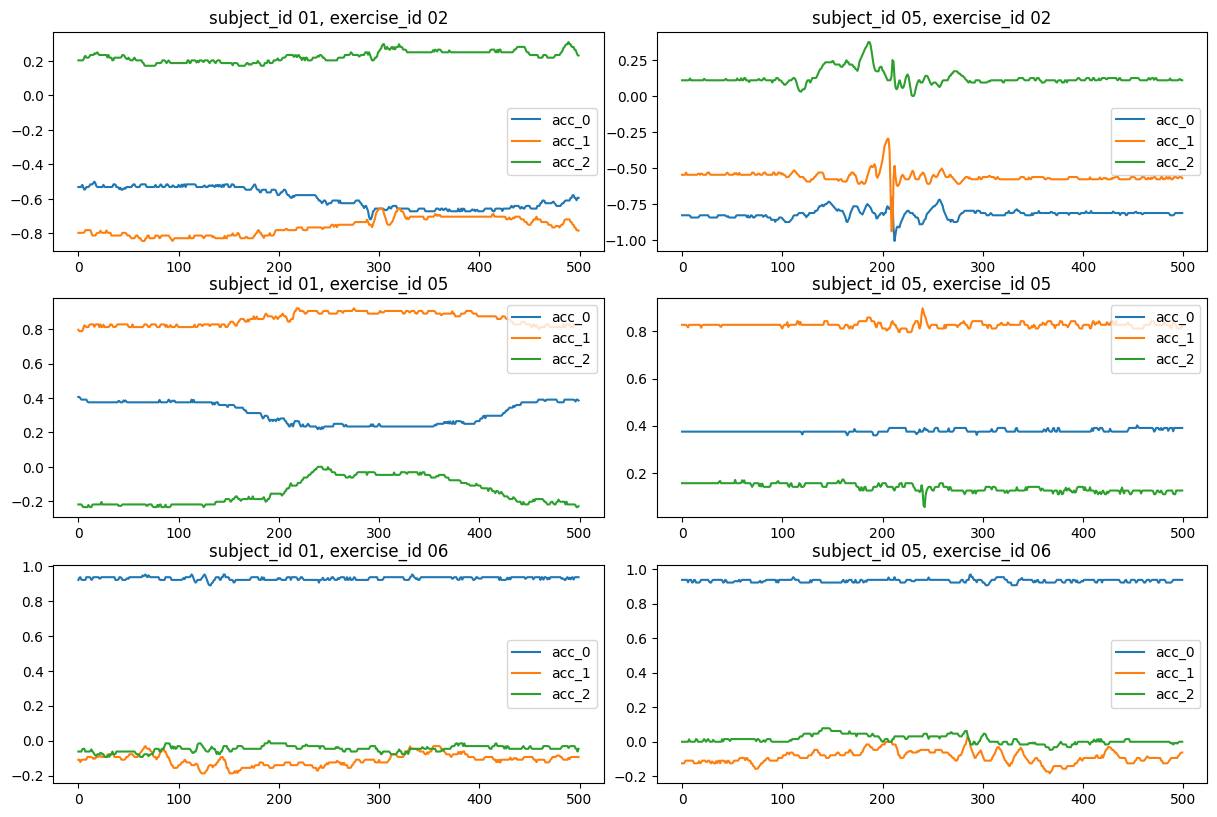

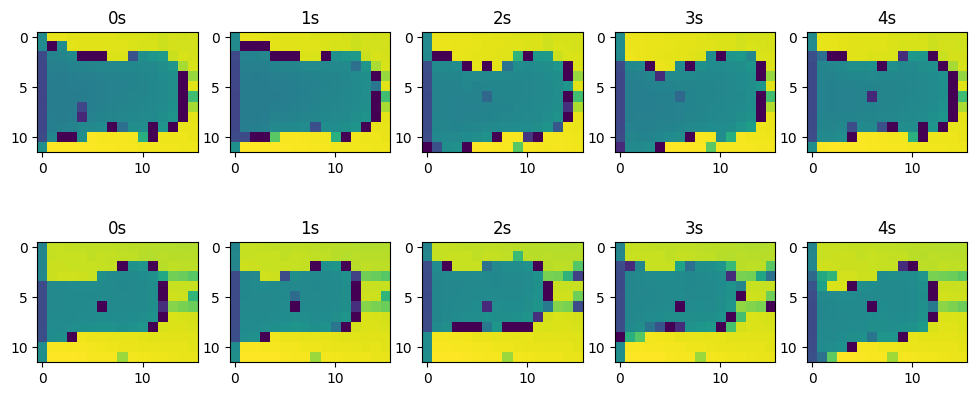

In [4]:
# 1.1. Visualize selected samples for both modalities

### Your code begins here ###
import matplotlib.pyplot as plt
import seaborn as sns

#Extract sensor data for [sensor, person, exercise]
def extract_data(sensor, subject_id, exercise_id):
    data = df_records_windowed[(df_records_windowed['sensor']==sensor)&(df_records_windowed['subject_id']==subject_id)&(df_records_windowed['exercise_id']==exercise_id)]
    return data

#Plotting acceleration sensor data
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,8))
fig.tight_layout(pad=2.0)
for i, person in enumerate(['01','05']):
    for j, exercise in enumerate(['02','05','06']):
        subject_acc = extract_data('acc', person, exercise).iloc[0]
        subject_acc['df'][['acc_0','acc_1','acc_2']].plot(ax=axes[j,i], title = "subject_id "+person+", exercise_id "+exercise)


#Plotting depth image data
fig2, axes2 = plt.subplots(nrows=2, ncols=5,figsize=(12,5))
fig.tight_layout(pad=0.1)
for t in range(5):
    for i, person in enumerate(['01','05']):
        subject_dc = extract_data('dc', person, exercise).iloc[0]
        frame_row = subject_dc['df'].drop('time', axis=1).iloc[t].values
        frame = np.array(frame_row).reshape(12, 16)
        axes2[i, t].imshow(frame, cmap='viridis')
        axes2[i, t].set_title(str(t)+"s")


# Helper functions for later visualization of CFs.
# This Confusion Matrix Visualization was created using ChatGPT4, specifically the heatmap using seaborn. 
def plot_confusion_matrix(conf_matrix, class_names, title='Confusion Matrix', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.heatmap(conf_matrix, 
                annot=True,  
                fmt='d',     
                cmap='YlGnBu',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)


    ax.set_title(title, pad=20)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)
    
    plt.tight_layout()


# Define class names (exercises) for future use. 
class_names = ['Ex 1', 'Ex 2', 'Ex 3', 'Ex 4', 'Ex 5', 'Ex 6', 'Ex 7']


For Task 1.1, we visualized selected samples from the accelerometer and depth camera modalities to gain a better understanding of the data. we defined an extract_data function to retrieve sensor data for specific subjects and exercises from the windowed dataframe.
To plot the accelerometer data, we created a grid of subplots with 3 rows and 2 columns. we iterated over subjects '01' and '05' and exercises '02', '05', and '06', extracting the first window of data for each combination. we plotted the acc_0, acc_1, and acc_2 columns as multi-dimensional time series, labeling each subplot with the corresponding subject and exercise.
For the depth camera data, we created another grid of subplots with 2 rows and 5 columns. Again, we iterated over the same subjects and exercises, but this time we extracted a single frame at each second (0-4s) within the first window. we reshaped the frame data into a 12x16 matrix and displayed it as a 2D image

<a id='task1'></a>
<div class=" alert alert-warning">

<p> <b>1.2</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
    
<p> Note: Training set should have 1486 windows and testing set should have 598 windows. In training set, acceleration data will have a window without a pair with depth camera data, that window should be dropped as it doesn't have a pair.<p>
  
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [5]:
# 1.2. Split samples based on subject ID into training and testing datasets for futher experiments

### Your code begins here ###
# Split the data into training and testing datasets
print("Original Data Shape", df_records_windowed.shape)
tmp_train_data = df_records_windowed[df_records_windowed['subject_id'].isin(['01', '02', '03', '04', '05', '06', '07'])]
tmp_test_data = df_records_windowed[df_records_windowed['subject_id'].isin(['08', '09', '10'])]

print("Tmp Train Data Shape", tmp_train_data.shape)
print("Tmp Test Data Shape", tmp_test_data.shape)

# Separate accelerometer and depth camera data
train_data_acc = tmp_train_data[tmp_train_data['sensor'] == 'acc']
train_data_dc = tmp_train_data[tmp_train_data['sensor'] == 'dc']
test_data_acc = tmp_test_data[tmp_test_data['sensor'] == 'acc']
test_data_dc = tmp_test_data[tmp_test_data['sensor'] == 'dc']

# Find the extra row in Train Data Acc
extra_row = train_data_acc[~train_data_acc.set_index(['subject_id', 'exercise_id', 'trial', 'window_idx']).index.isin(
    train_data_dc.set_index(['subject_id', 'exercise_id', 'trial', 'window_idx']).index
)]

# Display the extra row for sanity
print("Extra row in Train Data Acc:")
display(extra_row.head())

# Drop the extra row from Train Data Acc
train_data_acc = train_data_acc[train_data_acc.set_index(['subject_id', 'exercise_id', 'trial', 'window_idx']).index.isin(
    train_data_dc.set_index(['subject_id', 'exercise_id', 'trial', 'window_idx']).index
)]

# Verify the number of windows
print("Train Data Acc: ", train_data_acc.shape)
print("Train Data Dc: ", train_data_dc.shape)
print("Test Data Acc: ", test_data_acc.shape)
print("Test Data Dc: ", test_data_dc.shape)

## Your code ends here ###

Original Data Shape (4169, 7)
Tmp Train Data Shape (2973, 7)
Tmp Test Data Shape (1196, 7)
Extra row in Train Data Acc:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
407,02,06,1,act,acc,time acc_0 acc_1 acc_2 58...,29


Train Data Acc:  (1486, 7)
Train Data Dc:  (1486, 7)
Test Data Acc:  (598, 7)
Test Data Dc:  (598, 7)


In Task 1.2, we split the dataset into training and testing sets based on the subject IDs. Subjects '01' to '07' were assigned to the training set, while subjects '08' to '10' were used for the testing set. This split allows us to evaluate the model's performance on unseen subjects.
After the initial split, we noticed that the accelerometer data in the training set had one extra window compared to the depth camera data. To ensure paired data, we identified and dropped this extra row from the accelerometer training data.
The resulting training set contains 1486 windows for both the accelerometer and depth camera modalities, while the testing set has 598 windows for each modality. These numbers align with the expected window counts mentioned in the task description.

# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as 
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages 24-25) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

PCA(n_components=5)
Shape of Training Data after PCA:  (1486, 15)
Shape of Test Data after PCA Projection:  (598, 15)

 LinearDiscriminantAnalysis(n_components=5)
Shape of Training Data after LDA:  (1486, 15)
Shape of Test Data after LDA Projection:  (598, 15)

After Concatenation of PCA and LDA sequences we have: 
Shape of Training Data after PCA and LDA:  (1486, 30)
Shape of Test Data after PCA and LDA:  (598, 30)

F1 Score:  0.38247129714173395


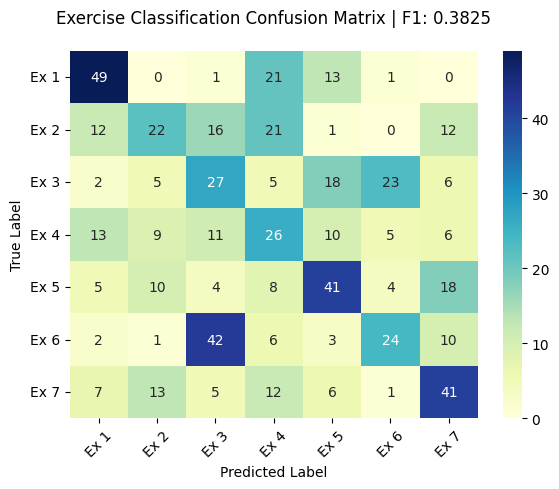

In [6]:
# 2.1

### Your code begins here ###

# Function Definitions for 2.1, 2.2
import numpy as np
from scipy.signal import resample
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score

# Function to downsample the accelerometer data
def downsample_acc_data(inner_df, target_rate=25):
    num_samples = int(5 * target_rate)  # 5 seconds at target rate
    downsampled_data = resample(inner_df[['acc_0', 'acc_1', 'acc_2']], num_samples)
    downsampled_df = pd.DataFrame(downsampled_data, columns=['acc_0', 'acc_1', 'acc_2'])
    return downsampled_df

# Function to standardize the accelerometer data
# TODO: Learn the transformation from the training dataset only. Don't use fit_transform for both training and testing. 
def standardize_acc_data(inner_df):
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(inner_df[['acc_0', 'acc_1', 'acc_2']])
    standardized_df = pd.DataFrame(standardized_data, columns=['acc_0', 'acc_1', 'acc_2'])
    return standardized_df

def fit_and_project_pca_for_acc(train_dataset, test_dataset, n_components=5):
    # First, fit PCA on all training data points to learn the transformation

    all_train_points = []
    for _, row in train_dataset.iterrows():
        for axis in ['acc_0', 'acc_1', 'acc_2']:
            points = row['df'][axis].values
            all_train_points.append(points)
    all_train_points = np.array(all_train_points)
    
    # print('All Train Points Shape: ', all_train_points.shape) # Should be (1486x3, 125)
    
    # Fit PCA on all points
    pca = PCA(n_components=n_components)
    pca.fit(all_train_points)
    
    # Transform each axis sequence separately
    pca_train_results = []
    for _, row in train_dataset.iterrows():
        pca_sequence = []
        for axis in ['acc_0', 'acc_1', 'acc_2']:
            points = row['df'][axis].values
            pca_points = pca.transform(points.reshape(1, -1))
            pca_sequence.append(pca_points.flatten())
        pca_train_results.append(np.concatenate(pca_sequence))
    
    # Transform test data
    pca_test_results = []
    for _, row in test_dataset.iterrows():
        pca_sequence = []
        for axis in ['acc_0', 'acc_1', 'acc_2']:
            points = row['df'][axis].values
            pca_points = pca.transform(points.reshape(1, -1))
            pca_sequence.append(pca_points.flatten())
        pca_test_results.append(np.concatenate(pca_sequence))
    
    return pca, np.array(pca_train_results), np.array(pca_test_results)

def fit_and_project_lda_for_acc(train_dataset, test_dataset, n_components=5):
    # First, fit LDA on all training points to learn the transformation
    all_train_points = []
    all_train_labels = []
    for _, row in train_dataset.iterrows():
        for axis in ['acc_0', 'acc_1', 'acc_2']:
            points = row['df'][axis].values
            all_train_points.append(points)
            all_train_labels.append(row['exercise_id'])
    all_train_points = np.array(all_train_points)
    all_train_labels = np.array(all_train_labels)
    
    # Fit LDA on all points
    lda = LDA(n_components=n_components)
    lda.fit(all_train_points, all_train_labels)
    
    # Transform each axis sequence separately
    lda_train_results = []
    for _, row in train_dataset.iterrows():
        lda_sequence = []
        for axis in ['acc_0', 'acc_1', 'acc_2']:
            points = row['df'][axis].values
            lda_points = lda.transform(points.reshape(1, -1))
            lda_sequence.append(lda_points.flatten())
        lda_train_results.append(np.concatenate(lda_sequence))
    
    # Transform test data
    lda_test_results = []
    for _, row in test_dataset.iterrows():
        lda_sequence = []
        for axis in ['acc_0', 'acc_1', 'acc_2']:
            points = row['df'][axis].values
            lda_points = lda.transform(points.reshape(1, -1))
            lda_sequence.append(lda_points.flatten())
        lda_test_results.append(np.concatenate(lda_sequence))
    
    return lda, np.array(lda_train_results), np.array(lda_test_results)

def compute_distances_and_classify(pca_train, pca_test, lda_train, lda_test, train_labels):
    predictions = []
    
    # For each test example
    for i in range(len(pca_test)):
        # Get current test example projections
        pca_test_example = pca_test[i]
        lda_test_example = lda_test[i]
        
        # Compute Euclidean distances for PCA and LDA
        pca_distances = np.sum((pca_train - pca_test_example) ** 2, axis=1)
        lda_distances = np.sum((lda_train - lda_test_example) ** 2, axis=1)
        
        # Normalize distances between 0 and 1
        pca_distances_norm = (pca_distances - np.min(pca_distances)) / (np.max(pca_distances) - np.min(pca_distances))
        lda_distances_norm = (lda_distances - np.min(lda_distances)) / (np.max(lda_distances) - np.min(lda_distances))
        
        # Fuse distances by averaging (arithmetic mean)
        fused_distances = 0.5 * (pca_distances_norm + lda_distances_norm)
        
        # Find nearest neighbor
        nearest_neighbor_idx = np.argmin(fused_distances)
        predictions.append(train_labels[nearest_neighbor_idx])
    
    return np.array(predictions)


# Main Execution of above functions for ACC data. 
# DOWNSAMPLING
# Apply downsampling to each DataFrame in the 'df' column using .loc for training dataset 
train_data_acc.loc[:, 'df'] = train_data_acc['df'].apply(lambda x: downsample_acc_data(x))
# Apply downsampling to each DataFrame in the 'df' column using .loc for testing dataset
test_data_acc.loc[:, 'df'] = test_data_acc['df'].apply(lambda x: downsample_acc_data(x))

# #STANDARDIZING
# Apply standardization to each DataFrame in the 'df' column of the training dataset
train_data_acc.loc[:, 'df'] = train_data_acc['df'].apply(lambda x: standardize_acc_data(x))
# Apply standardization to each DataFrame in the 'df' column of the testing dataset
test_data_acc.loc[:, 'df'] = test_data_acc['df'].apply(lambda x: standardize_acc_data(x))

#PCA and LDA
pca, pca_acc_training, pca_acc_test = fit_and_project_pca_for_acc(train_data_acc, test_data_acc, 5)
print(pca)
print('Shape of Training Data after PCA: ',pca_acc_training.shape)
print('Shape of Test Data after PCA Projection: ',pca_acc_test.shape)

lda, lda_acc_training, lda_acc_test = fit_and_project_lda_for_acc(train_data_acc, test_data_acc, 5)
print('\n',lda)
print('Shape of Training Data after LDA: ', lda_acc_training.shape)
print('Shape of Test Data after LDA Projection: ', lda_acc_test.shape)

# Concatenated Sequences after PCA and LDA
print('\nAfter Concatenation of PCA and LDA sequences we have: ')
pca_lda_train = np.hstack((pca_acc_training, lda_acc_training))
pca_lda_test = np.hstack((pca_acc_test, lda_acc_test))
print('Shape of Training Data after PCA and LDA: ', pca_lda_train.shape)
print('Shape of Test Data after PCA and LDA: ', pca_lda_test.shape)

# Making Predictions
acc_predictions = compute_distances_and_classify(
    pca_acc_training, 
    pca_acc_test,
    lda_acc_training, 
    lda_acc_test,
    train_data_acc['exercise_id'].values
)

conf_matrix = confusion_matrix(test_data_acc['exercise_id'].values, acc_predictions)
f1 = f1_score(test_data_acc['exercise_id'].values, acc_predictions, average='macro')

print("\nF1 Score: ", f1)
titleCF= "Exercise Classification Confusion Matrix |" + f" F1: {f1:.4f}"
plot_confusion_matrix(conf_matrix, class_names, title=titleCF)
plt.show()
### Your code ends here ###


For Task 2.1, we focused on building a model for the accelerometer data using a combination of PCA, LDA, and nearest neighbor classification. we started by downsampling the data from 100 Hz to 25 Hz to obtain a 125x3 matrix for each 5-second window. This was done using the scipy.signal.resample function. we also standardized the data along each axis to have zero mean and unit variance.

Next, we fitted PCA and LDA on both the training  and test datasets, reducing the dimensionality to a 5-dimensional subspace for the accelerometer data. In case of the training dataset, we applied the PCA and LDA to each axis of the Accelerometer data (acc_0, acc_1, acc_2) by inverting 125x3 matrix to a 3x125 matrix for each window, which lead to us having 5 best samples across each axis, instead of a 125 samples. This effectively gave us the 1486x5 matrix for each axis, which became 1486x15 matrix when concatenated for all 3 axes for each dimensionality reduction technique. Similarly, when we reduced the test set using the same approach, we had a 598x15 matrix. Finally, we concatenated the results of PCA and LDA to form 1486x30 and 598x30 matrix for the training and test sets respectively.  

The fusion of PCA and LDA was performed using the nearest neighbor method, as presented in Lecture 3. Lastly, we evaluated the model's performance on the test set. The confusion matrix and F1 score were calculated to assess the classification results. The obtained F1 score of 0.3825 falls slightly below the expected range of 0.40 to 0.50 mentioned in the task description.

<a id='task2'></a>
<div class=" alert alert-warning">
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

PCA(n_components=5)
Shape of Training Data after PCA:  (1486, 25)
Shape of Test Data after PCA Projection:  (598, 25)

 LinearDiscriminantAnalysis(n_components=5)
Shape of Training Data after LDA:  (1486, 25)
Shape of Test Data after LDA Projection:  (598, 25)

After Concatenation of PCA and LDA we have: 
Shape of Training Data after PCA and LDA:  (1486, 50)
Shape of Test Data after PCA and LDA:  (598, 50)

F1 Score:  0.4245854590342084


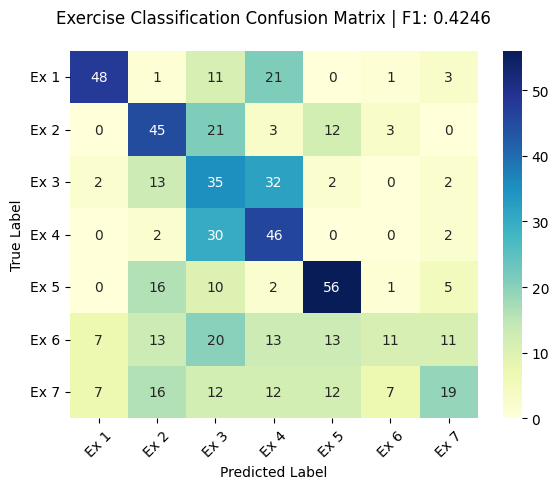

In [7]:
# 2.2

### Your code begins here ###
def standardize_dc_data(inner_df):
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(inner_df)
    return pd.DataFrame(standardized_data)

def fit_and_project_pca_for_dc(train_dataset, test_dataset, n_components=5):
    # First, fit PCA on all training images to learn the transformation
    all_train_images = []
    for _, row in train_dataset.iterrows():
        for i in range(5):  # 5 images per window
            image = row['df'].iloc[i].values.flatten()
            all_train_images.append(image)
    all_train_images = np.array(all_train_images)
    
    # print('All Train Images: ', all_train_images.shape) # We process each window shape, should be (1486x5, 193)

    # Fit PCA on all training images
    pca = PCA(n_components=n_components)
    pca.fit(all_train_images)
    
    # Transform each image sequence separately
    pca_train_results = []
    for _, row in train_dataset.iterrows():
        pca_sequence = []
        for i in range(5):  # 5 images per window
            image = row['df'].iloc[i].values.flatten()
            pca_image = pca.transform(image.reshape(1, -1))
            pca_sequence.append(pca_image.flatten())
        pca_train_results.append(np.concatenate(pca_sequence))
    
    # Transform test data
    pca_test_results = []
    for _, row in test_dataset.iterrows():
        pca_sequence = []
        for i in range(5):  # 5 images per window
            image = row['df'].iloc[i].values.flatten()
            pca_image = pca.transform(image.reshape(1, -1))
            pca_sequence.append(pca_image.flatten())
        pca_test_results.append(np.concatenate(pca_sequence))
    
    return pca, np.array(pca_train_results), np.array(pca_test_results)

def fit_and_project_lda_for_dc(train_dataset, test_dataset, n_components=5):
    # First, fit LDA on all training images to learn the transformation
    all_train_images = []
    all_train_labels = []
    for _, row in train_dataset.iterrows():
        for i in range(5):  # 5 images per window
            image = row['df'].iloc[i].values.flatten()
            all_train_images.append(image)
            all_train_labels.append(row['exercise_id'])
    all_train_images = np.array(all_train_images)
    all_train_labels = np.array(all_train_labels)
    
    # Fit LDA on all training images
    lda = LDA(n_components=n_components)
    lda.fit(all_train_images, all_train_labels)
    
    # Transform each image sequence separately
    lda_train_results = []
    for _, row in train_dataset.iterrows():
        lda_sequence = []
        for i in range(5):  # 5 images per window
            image = row['df'].iloc[i].values.flatten()
            lda_image = lda.transform(image.reshape(1, -1))
            lda_sequence.append(lda_image.flatten())
        lda_train_results.append(np.concatenate(lda_sequence))
    
    # Transform test data
    lda_test_results = []
    for _, row in test_dataset.iterrows():
        lda_sequence = []
        for i in range(5):  # 5 images per window
            image = row['df'].iloc[i].values.flatten()
            lda_image = lda.transform(image.reshape(1, -1))
            lda_sequence.append(lda_image.flatten())
        lda_test_results.append(np.concatenate(lda_sequence))
    
    return lda, np.array(lda_train_results), np.array(lda_test_results)

# STANDARDIZE
train_data_dc.loc[:, 'df'] = train_data_dc['df'].apply(standardize_dc_data)
test_data_dc.loc[:, 'df'] = test_data_dc['df'].apply(standardize_dc_data)

# PCA and LDA
pca, pca_dc_training, pca_dc_test = fit_and_project_pca_for_dc(train_data_dc, test_data_dc, 5)
print(pca)
print('Shape of Training Data after PCA: ',pca_dc_training.shape)
print('Shape of Test Data after PCA Projection: ',pca_dc_test.shape)

lda, lda_dc_training, lda_dc_test = fit_and_project_lda_for_dc(train_data_dc, test_data_dc, 5)
print('\n', lda)
print('Shape of Training Data after LDA: ', lda_dc_training.shape)
print('Shape of Test Data after LDA Projection: ', lda_dc_test.shape)

# Concatenated Sequences
print('\nAfter Concatenation of PCA and LDA we have: ')
pca_lda_train = np.hstack((pca_dc_training, lda_dc_training))
pca_lda_test = np.hstack((pca_dc_test, lda_dc_test))
print('Shape of Training Data after PCA and LDA: ', pca_lda_train.shape)
print('Shape of Test Data after PCA and LDA: ', pca_lda_test.shape)


dc_predictions = compute_distances_and_classify(
    pca_dc_training, pca_dc_test,
    lda_dc_training, lda_dc_test,
    train_data_dc['exercise_id'].values
)

conf_matrix = confusion_matrix(test_data_dc['exercise_id'].values, dc_predictions)
f1 = f1_score(test_data_dc['exercise_id'].values, dc_predictions, average='macro')

print("\nF1 Score: ", f1)
titleCF= "Exercise Classification Confusion Matrix |" + f" F1: {f1:.4f}"
plot_confusion_matrix(conf_matrix, class_names, title=titleCF)
plt.show()


### Your code ends here ###

We applied PCA and LDA transformations to reduce the dimensionality of the depth camera images. Similar to the accelerometer data, we standardized the image data to have zero mean and unit variance before applying the transformations.

We fitted PCA and LDA on all the training images, which were originally 12x16 pixels (192-dimensional in vectorized form). Each window consisted of a 5x192 matrix, which was reduced to a 5x5 matrix after applying a dimensionality technique. 

After fitting the transformations, we applied them to both the training and test examples, transforming each image into the lower-dimensional feature space. Since there were 5 images per window, we concatenated the transformed features of each image sequence into a single vector of size 5x1x(5), basically leading to (1x25) matrix for each window. At the end, our training and test sets had 1486x25 and 598x25 shapes respectively for each reduction technique. Concatenating the results of PCA and LDA, we had a the final feature matrices as 1486x50 (25 from PCA, and 25 from LDA) and 598x50. 

Next, we performed the fusion of PCA and LDA features using the nearest neighbor method, similar to Task 2.1. we evaluated the model's performance on the test set by calculating the confusion matrix and F1 score.The obtained F1 score of 0.4246 falls within the expected range of 0.40 to 0.50 mentioned in the task description.

# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as 
<br>   

<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>

Document your work.
    
</div>

In [8]:
# 3.1

### Your code begins here ###

def calculate_statistical_features(inner_df):
    stats_vector = []
    for axis in ['acc_0', 'acc_1', 'acc_2']:
        mean = inner_df[axis].mean()
        std = inner_df[axis].std()
        stats_vector.extend([mean, std])
    return np.array(stats_vector)

# Main Execution of above functions for ACC data. 
# DOWNSAMPLING
# Apply downsampling to each DataFrame in the 'df' column using .loc for training dataset 
train_data_acc.loc[:, 'df'] = train_data_acc['df'].apply(lambda x: downsample_acc_data(x))
# Apply downsampling to each DataFrame in the 'df' column using .loc for testing dataset
test_data_acc.loc[:, 'df'] = test_data_acc['df'].apply(lambda x: downsample_acc_data(x))

# #STANDARDIZING
# Apply standardization to each DataFrame in the 'df' column of the training dataset
train_data_acc.loc[:, 'df'] = train_data_acc['df'].apply(lambda x: standardize_acc_data(x))
# Apply standardization to each DataFrame in the 'df' column of the testing dataset
test_data_acc.loc[:, 'df'] = test_data_acc['df'].apply(lambda x: standardize_acc_data(x))

# Apply PCA for n_components = 10
pca, pca_acc_training, pca_acc_test = fit_and_project_pca_for_acc(train_data_acc, test_data_acc, 10)
print(pca)
print('Shape of Training Data after PCA: ',pca_acc_training.shape)
print('Shape of Test Data after PCA Projection: ',pca_acc_test.shape)

# Calculate statistical features for training data
train_stats = np.array([calculate_statistical_features(row['df']) 
                       for _, row in train_data_acc.iterrows()])
test_stats = np.array([calculate_statistical_features(row['df']) 
                      for _, row in test_data_acc.iterrows()])

print('\nShape of Statistical Features Training: ', train_stats.shape)  # Should be (1486, 6)
print('Shape of Statistical Features Test: ', test_stats.shape)      # Should be (598, 6)

# Combine PCA and statistical features
pca_acc_with_stats_train = np.hstack((pca_acc_training, train_stats))
pca_acc_with_stats_test = np.hstack((pca_acc_test, test_stats))

print('\nAfter combining PCA and Statistical Features:')
print('Shape of Training Features: ', pca_acc_with_stats_train.shape)  # Should be (1486, 36)
print('Shape of Test Features: ', pca_acc_with_stats_test.shape)      # Should be (598, 36)

### Your code ends here ###

PCA(n_components=10)
Shape of Training Data after PCA:  (1486, 30)
Shape of Test Data after PCA Projection:  (598, 30)

Shape of Statistical Features Training:  (1486, 6)
Shape of Statistical Features Test:  (598, 6)

After combining PCA and Statistical Features:
Shape of Training Features:  (1486, 36)
Shape of Test Features:  (598, 36)


In Task 3.1, our focus was on extracting features from the accelerometer data as part of the multimodal classification process. We began by preprocessing the data, applying the same downsampling and standardization techniques as in previous tasks. This involved reducing the sampling rate from 100 Hz to 25 Hz and normalizing the data to have zero mean and unit variance.

To reduce the dimensionality of the accelerometer data, we employed Principal Component Analysis (PCA). We selected 10 principal components to retain the most essential information while significantly reducing the feature space. The PCA transformation was learned using the training data and subsequently applied to both the training and test sets.

In addition to PCA, we introduced a new feature extraction step by calculating statistical features from the accelerometer data. We defined a function called *calculate_statistical_features* that computed the mean and standard deviation for each axis (acc_0, acc_1, acc_2). This resulted in a total of 6 statistical features per window (2 features per axis).

The PCA-transformed data, with 10 components per axis, had a shape of (1486, 30) for the training set and (598, 30) for the test set. The statistical features, on the other hand, had a shape of (1486, 6) for training and (598, 6) for testing.

Finally, we concatenated the PCA features and statistical features using `np.hstack` to create a combined feature vector. The resulting feature vectors had a shape of (1486, 36) for the training set and (598, 36) for the test set. This shape comes from the fact that we had 30 PCA components (10 per axis) and 6 statistical features, totaling 36 features per window.

By incorporating both PCA features and statistical features, we aim to capture different aspects of the accelerometer data that can contribute to improved classification performance. The PCA features represent the most significant patterns and variations in the data, while the statistical features provide summary measures for each axis.

These extracted features will be utilized in the subsequent steps for multimodal classification, where they will be combined with features derived from the depth camera data to create a comprehensive feature representation.

<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>

Document your work.
    
</div>

In [9]:
# 3.2

### Your code begins here ###
# STANDARDIZE
train_data_dc.loc[:, 'df'] = train_data_dc['df'].apply(standardize_dc_data)
test_data_dc.loc[:, 'df'] = test_data_dc['df'].apply(standardize_dc_data)

# PCA for DC data with 10 components
pca, pca_dc_training, pca_dc_test = fit_and_project_pca_for_dc(train_data_dc, test_data_dc, 10)
print(pca)
print('Shape of Training Data after PCA: ',pca_dc_training.shape)
print('Shape of Test Data after PCA Projection: ',pca_dc_test.shape)

### Your code ends here ###

PCA(n_components=10)
Shape of Training Data after PCA:  (1486, 50)
Shape of Test Data after PCA Projection:  (598, 50)


In Task 3.2, we applied PCA to the depth camera images, following a similar approach as in Task 2.2. However, this time we chose to retain 10 principal components instead of 5. This allowed us to capture more information from the depth images while still reducing the dimensionality.
Before applying PCA, we standardized the depth camera data to have zero mean and unit variance using the standardize_dc_data function. We then used the fit_and_project_pca_for_dc function to fit the PCA transformation on the training images and transform both the training and test images into the new feature space.
The resulting PCA-transformed features had a shape of (1486, 50) for the training set and (598, 50) for the test set. Each window was represented by a 50-dimensional feature vector, corresponding to 10 principal components for each of the 5 depth images in the sequence

<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>

Note: Normalize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes. (The expected F1 score for this task should generally fall within the range of 55 to 70)
    
</div>

Training Joint Feature Set:  (1486, 86)
Test Joint Feature Set:  (598, 86)

SVM F1 Score: 0.5799283678500604 | Naive Bayes F1 Score: 0.591043948846736


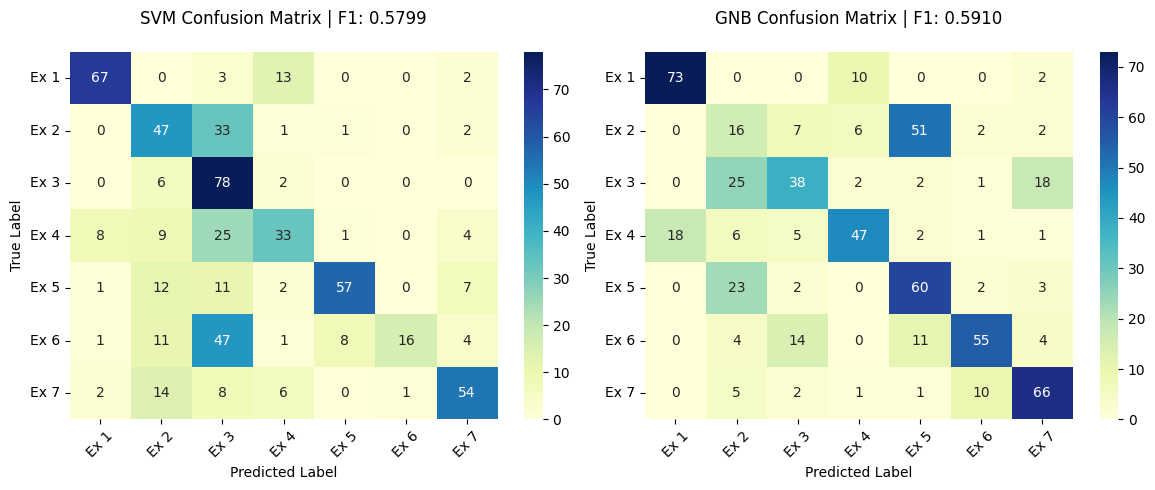

In [10]:
# 3.3

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

### Your code begins here ###

# Create a Joint Feature set
acc_dc_joint_training = np.hstack((pca_acc_with_stats_train, pca_dc_training))
print('Training Joint Feature Set: ', acc_dc_joint_training.shape)

acc_dc_joint_test = np.hstack((pca_acc_with_stats_test, pca_dc_test))
print('Test Joint Feature Set: ', acc_dc_joint_test.shape)

scaler = MinMaxScaler()
normalized_acc_dc_joint_training = scaler.fit_transform(acc_dc_joint_training)
normalized_acc_dc_joint_test = scaler.transform(acc_dc_joint_test)

# Initializing Classifiers here. 
svm_classifier = SVC(kernel= 'rbf')
gnb_classifier = GaussianNB()

train_labels = train_data_acc['exercise_id'].values
test_labels = test_data_acc['exercise_id'].values

# Training
svm_classifier.fit(normalized_acc_dc_joint_training, train_labels)
gnb_classifier.fit(normalized_acc_dc_joint_training, train_labels)

# Making Predictions on the Test Set
svm_predictions = svm_classifier.predict(normalized_acc_dc_joint_test)
gnb_predictions = gnb_classifier.predict(normalized_acc_dc_joint_test)

svm_f1 = f1_score(test_labels, svm_predictions, average='macro')
gnb_f1 = f1_score(test_labels, gnb_predictions, average='macro')
svm_conf_matrix = confusion_matrix(test_labels, svm_predictions)
gnb_conf_matrix = confusion_matrix(test_labels, gnb_predictions)

print(f"\nSVM F1 Score: {svm_f1} | Naive Bayes F1 Score: {gnb_f1}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
titleCF1= "SVM Confusion Matrix |" + f" F1: {svm_f1:.4f}"
titleCF2= "GNB Confusion Matrix |" + f" F1: {gnb_f1:.4f}"
plot_confusion_matrix(svm_conf_matrix, class_names, title=titleCF1, ax=axes[0])
plot_confusion_matrix(gnb_conf_matrix, class_names, title=titleCF2, ax=axes[1])
plt.show()
### Your code ends here ###

We combined the features extracted from the accelerometer data in Task 3.1 with the depth camera features from Task 3.2. This resulted in an 86-dimensional feature vector for each example, consisting of 36 features from the accelerometer data (30 PCA components + 6 statistical features) and 50 features from the depth camera data (10 PCA components per image).

To prepare the data for classification, we normalized the joint feature set using the MinMaxScaler from scikit-learn. This scaled the feature values between 0 and 1 based on the training data.

We then trained two classifiers on the normalized joint feature set: a Support Vector Machine (SVM) with an RBF kernel and a Gaussian Naive Bayes classifier. We used the default parameter values for both classifiers.

After training the classifiers, we evaluated their performance on the test set using F1 scores and confusion matrices. The SVM achieved an F1 score of 0.5799, while the Naive Bayes classifier obtained an F1 score of 0.5910. These scores fall within the expected range of 0.55 to 0.70 mentioned in the task description, showing an adequate performance. 

# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as 
<br>
<br> 
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0). 
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$.<br>
Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>

Note: Normalize the data along each axis.
<br>

Document your work, answer the given question, evaluate the results, and analyse the outcomes.
    
</div>

Training accelerometer classifiers...

Best parameters for accelerometer SVM: {'C': 10.0, 'gamma': 1.0}
(Training) Best F1 score for accelerometer SVM: 0.6264948522989162

Best parameters for accelerometer AdaBoost: {'learning_rate': 0.5, 'n_estimators': 500}
(Training) Best F1 score for accelerometer AdaBoost: 0.3260350983577583

Test Set Performance:
Accelerometer SVM F1: 0.4814666001292912 | Accelerometer AdaBoost F1: 0.2866025856542646


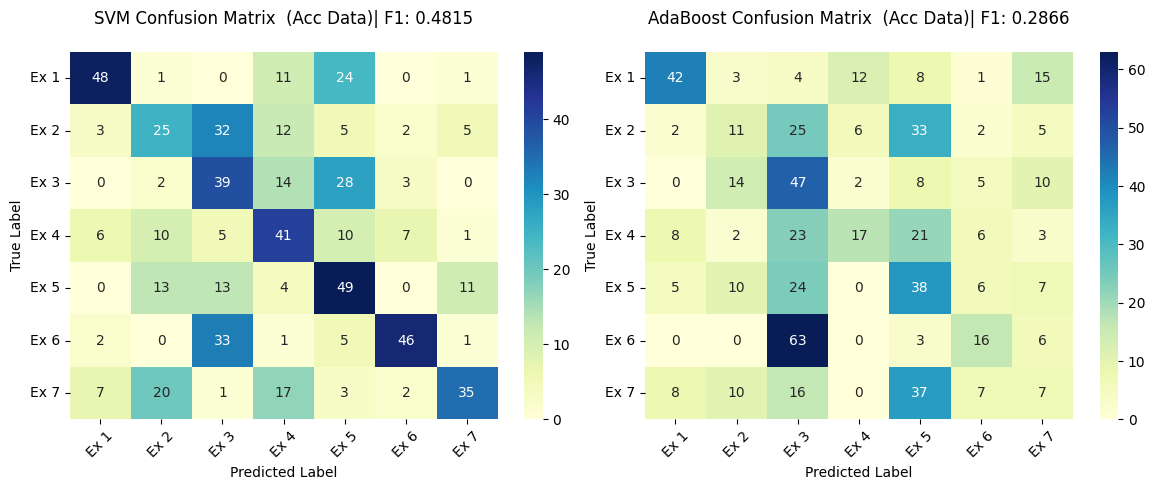

Training depth camera classifiers...

Best parameters for depth camera SVM: {'C': 10.0, 'gamma': 2.0}
(Training) Best F1 score for depth camera SVM: 0.8382976774479465

Best parameters for depth camera AdaBoost: {'learning_rate': 0.75, 'n_estimators': 1000}
(Training) Best F1 score for depth camera AdaBoost: 0.5133274047600037

Test Set Performance:
Depth Camera SVM F1: 0.7758387533560928 | Depth Camera AdaBoost F1: 0.39774670805715767


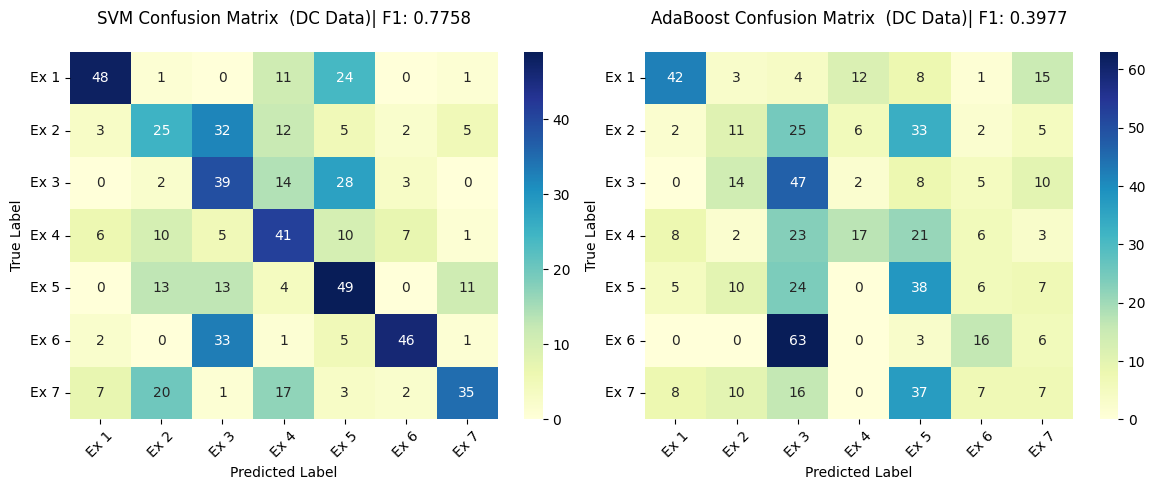

In [11]:
# 4.1

### Your code begins here ###
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*SAMME.R algorithm.*")

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# Setting up parameter grids
svm_param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'gamma': [0.1, 0.25, 0.5, 0.75, 1.0, 2.0]
}

adaboost_param_grid = {
    'n_estimators': [50, 100, 500, 1000],
    'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0]
}

train_labels = train_data_acc['exercise_id'].values
test_labels = test_data_acc['exercise_id'].values

# ACC Data
# Normalizing acc from 3.1. (1486x26 matrix)
scaler = MinMaxScaler()
acc_train_normalized = scaler.fit_transform(pca_acc_with_stats_train)
acc_test_normalized = scaler.transform(pca_acc_with_stats_test)

# Grid search for acc data
svm_acc = GridSearchCV(
    SVC(kernel='rbf', random_state=0, probability=True),
    svm_param_grid,
    cv=10,
    scoring='f1_macro', 
    n_jobs=-1
)

adaboost_acc = GridSearchCV(
    AdaBoostClassifier(random_state=0),
    adaboost_param_grid,
    cv=10,
    scoring='f1_macro',
    n_jobs=-1
)

# Train accelerometer classifiers
print("Training accelerometer classifiers...")
svm_acc.fit(acc_train_normalized, train_labels)
adaboost_acc.fit(acc_train_normalized, train_labels)

# Saving best performing models
best_svm_acc = svm_acc.best_estimator_
best_adaboost_acc = adaboost_acc.best_estimator_

print("\nBest parameters for accelerometer SVM:", svm_acc.best_params_)
print("(Training) Best F1 score for accelerometer SVM:", svm_acc.best_score_)
print("\nBest parameters for accelerometer AdaBoost:", adaboost_acc.best_params_)
print("(Training) Best F1 score for accelerometer AdaBoost:", adaboost_acc.best_score_)

print("\nTest Set Performance:")
svm_acc_predictions = best_svm_acc.predict(acc_test_normalized)
adaboost_acc_predictions = best_adaboost_acc.predict(acc_test_normalized)

acc_svm_f1 = f1_score(test_labels, svm_acc_predictions, average='macro')
acc_adaboost_f1 = f1_score(test_labels, adaboost_acc_predictions, average='macro')

print(f"Accelerometer SVM F1: {acc_svm_f1} | Accelerometer AdaBoost F1: {acc_adaboost_f1}")

svm_acc_conf_matrix = confusion_matrix(test_labels, svm_acc_predictions)
adaboost_acc_conf_matrix = confusion_matrix(test_labels, adaboost_acc_predictions)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
titleCF1= "SVM Confusion Matrix  (Acc Data)|" + f" F1: {acc_svm_f1:.4f}"
titleCF2= "AdaBoost Confusion Matrix  (Acc Data)|" + f" F1: {acc_adaboost_f1:.4f}"
plot_confusion_matrix(svm_acc_conf_matrix, class_names, title=titleCF1, ax=axes[0])
plot_confusion_matrix(adaboost_acc_conf_matrix, class_names, title=titleCF2, ax=axes[1])
plt.show()


# DC Data
# Normalizing DC Data from 3.2.  (1486 x 50)
scaler_dc = MinMaxScaler()
dc_train_normalized = scaler_dc.fit_transform(pca_dc_training)
dc_test_normalized = scaler_dc.transform(pca_dc_test)

# Grid search for acc data
svm_dc = GridSearchCV(
    SVC(kernel='rbf', random_state=0, probability=True),
    svm_param_grid,
    cv=10,
    scoring='f1_macro', 
    n_jobs=-1
)

adaboost_dc = GridSearchCV(
    AdaBoostClassifier(random_state=0),
    adaboost_param_grid,
    cv=10,
    scoring='f1_macro',
    n_jobs=-1
)

# Train DC classifiers
train_labels = train_data_dc['exercise_id'].values
test_labels = test_data_dc['exercise_id'].values

print("Training depth camera classifiers...")
svm_dc.fit(dc_train_normalized, train_labels)
adaboost_dc.fit(dc_train_normalized, train_labels)

# Saving best performing models
best_svm_dc = svm_dc.best_estimator_
best_adaboost_dc = adaboost_dc.best_estimator_

print("\nBest parameters for depth camera SVM:", svm_dc.best_params_)
print("(Training) Best F1 score for depth camera SVM:", svm_dc.best_score_)
print("\nBest parameters for depth camera AdaBoost:", adaboost_dc.best_params_)
print("(Training) Best F1 score for depth camera AdaBoost:", adaboost_dc.best_score_)

print("\nTest Set Performance:")
svm_dc_predictions = best_svm_dc.predict(dc_test_normalized)
adaboost_dc_predictions = best_adaboost_dc.predict(dc_test_normalized)

dc_svm_f1 = f1_score(test_labels, svm_dc_predictions, average='macro')
dc_adaboost_f1 = f1_score(test_labels, adaboost_dc_predictions, average='macro')

print(f"Depth Camera SVM F1: {dc_svm_f1} | Depth Camera AdaBoost F1: {dc_adaboost_f1}")

svm_dc_conf_matrix = confusion_matrix(test_labels, svm_dc_predictions)
adaboost_dc_conf_matrix = confusion_matrix(test_labels, adaboost_dc_predictions)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
titleCF1= "SVM Confusion Matrix  (DC Data)|" + f" F1: {dc_svm_f1:.4f}"
titleCF2= "AdaBoost Confusion Matrix  (DC Data)|" + f" F1: {dc_adaboost_f1:.4f}"
plot_confusion_matrix(svm_acc_conf_matrix, class_names, title=titleCF1, ax=axes[0])
plot_confusion_matrix(adaboost_acc_conf_matrix, class_names, title=titleCF2, ax=axes[1])
plt.show()
### Your code ends here ###

Here, we trained separate classifiers for the accelerometer and depth camera data using the features from Task 3. The goal was to find the best hyperparameters for each classifier and modality.
We used grid search with 10-fold cross-validation to tune the hyperparameters. For SVM, we tried different values for C and gamma. For AdaBoost, we varied the number of estimators and learning rate.
Before training, we normalized the features using MinMaxScaler. For the accelerometer data, we used fit_transform on the training set and transform on the test set. This means the scaler learned the scaling parameters from the training data and applied them to both sets.
For the depth camera data, we created a new scaler (scaler_dc) and used fit_transform on the training set and transform on the test set. This ensures that the scaling parameters are learned only from the training data and applied consistently.
After finding the best hyperparameters, we trained the classifiers on the full training set. The SVM performed better than AdaBoost for both modalities on the test set.
However, there's a risk of overfitting when tuning hyperparameters on the entire training set. The models might become too complex and not generalize well. Using a separate validation set or nested cross-validation could help mitigate this.
In summary, we trained individual classifiers for each modality, tuned hyperparameters using grid search, and evaluated performance on the test set. The results showed SVM outperforming AdaBoost

<a id='task4'></a>
<div class=" alert alert-warning">


<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

In [12]:
# 4.2

### Your code begins here ###
# Get probability predictions for ACC data
acc_svm_probs = best_svm_acc.predict_proba(acc_test_normalized)
acc_adaboost_probs = best_adaboost_acc.predict_proba(acc_test_normalized)

# Get probability predictions for DC data
dc_svm_probs = best_svm_dc.predict_proba(dc_test_normalized)
dc_adaboost_probs = best_adaboost_dc.predict_proba(dc_test_normalized)

# Printing shapes for verfication. 
print("Probability array shapes:")
print("ACC-SVM:", acc_svm_probs.shape)
print("ACC-AdaBoost:", acc_adaboost_probs.shape)
print("DC-SVM:", dc_svm_probs.shape)
print("DC-AdaBoost:", dc_adaboost_probs.shape)

# Creating a dictionary of predictions for difference modalities and classifiers to use later in 4.3
probability_predictions = {
    'acc_svm': acc_svm_probs,
    'acc_adaboost': acc_adaboost_probs,
    'dc_svm': dc_svm_probs,
    'dc_adaboost': dc_adaboost_probs
}
### Your code ends here ###

Probability array shapes:
ACC-SVM: (598, 7)
ACC-AdaBoost: (598, 7)
DC-SVM: (598, 7)
DC-AdaBoost: (598, 7)


We obtained the probability predictions for each trained classifier on both modalities using the test set. We used the predict_proba method to get these probabilities.
The probability arrays have a shape of (598, 7) for all classifiers, indicating 598 test instances and 7 classes. We stored these predictions in a dictionary called probability_predictions for later use in Task 4.3.

<a id='task4'></a>
<div class=" alert alert-warning">
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>


Results for SVM_acc + SVM_dc:


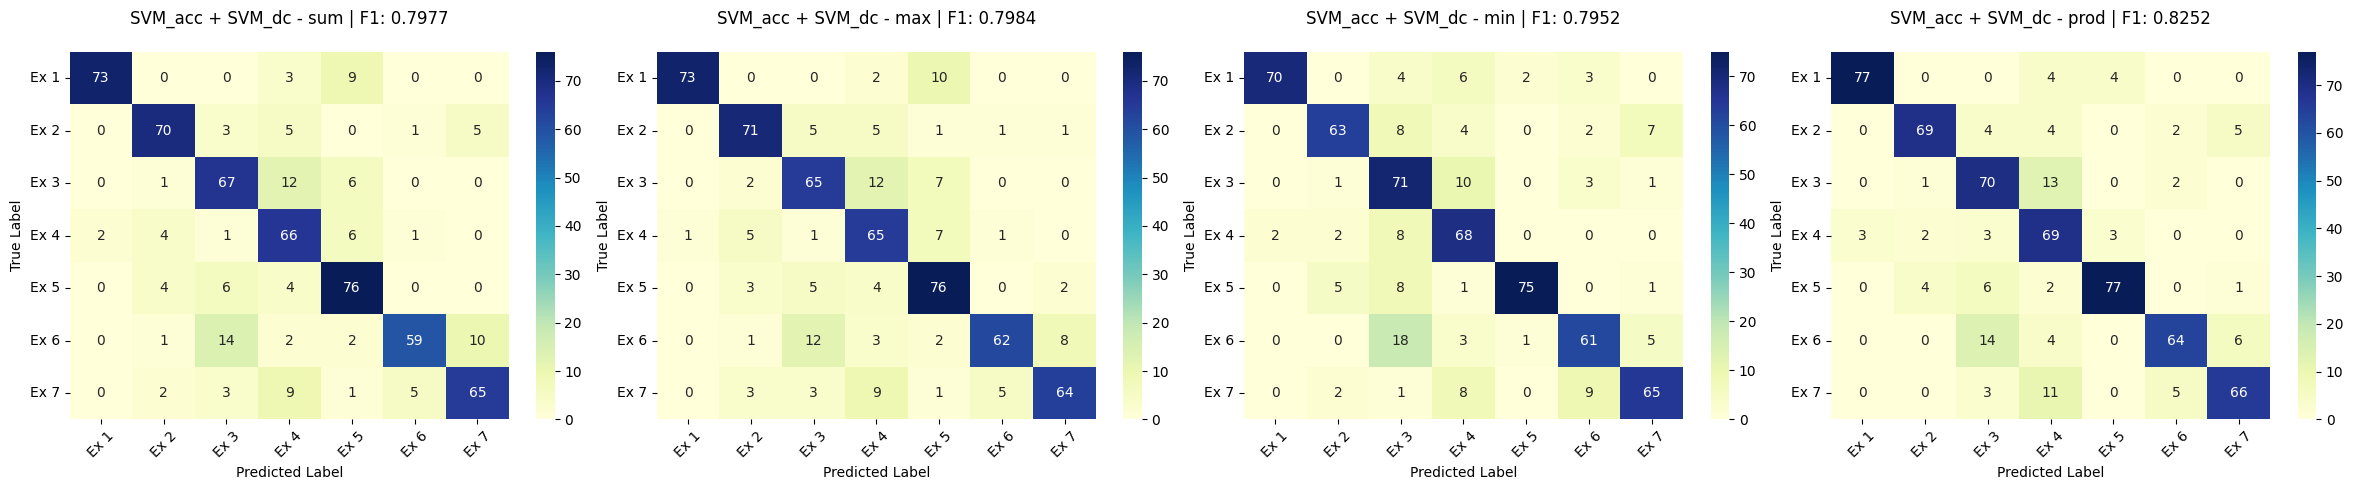


Results for AdaBoost_acc + AdaBoost_dc:


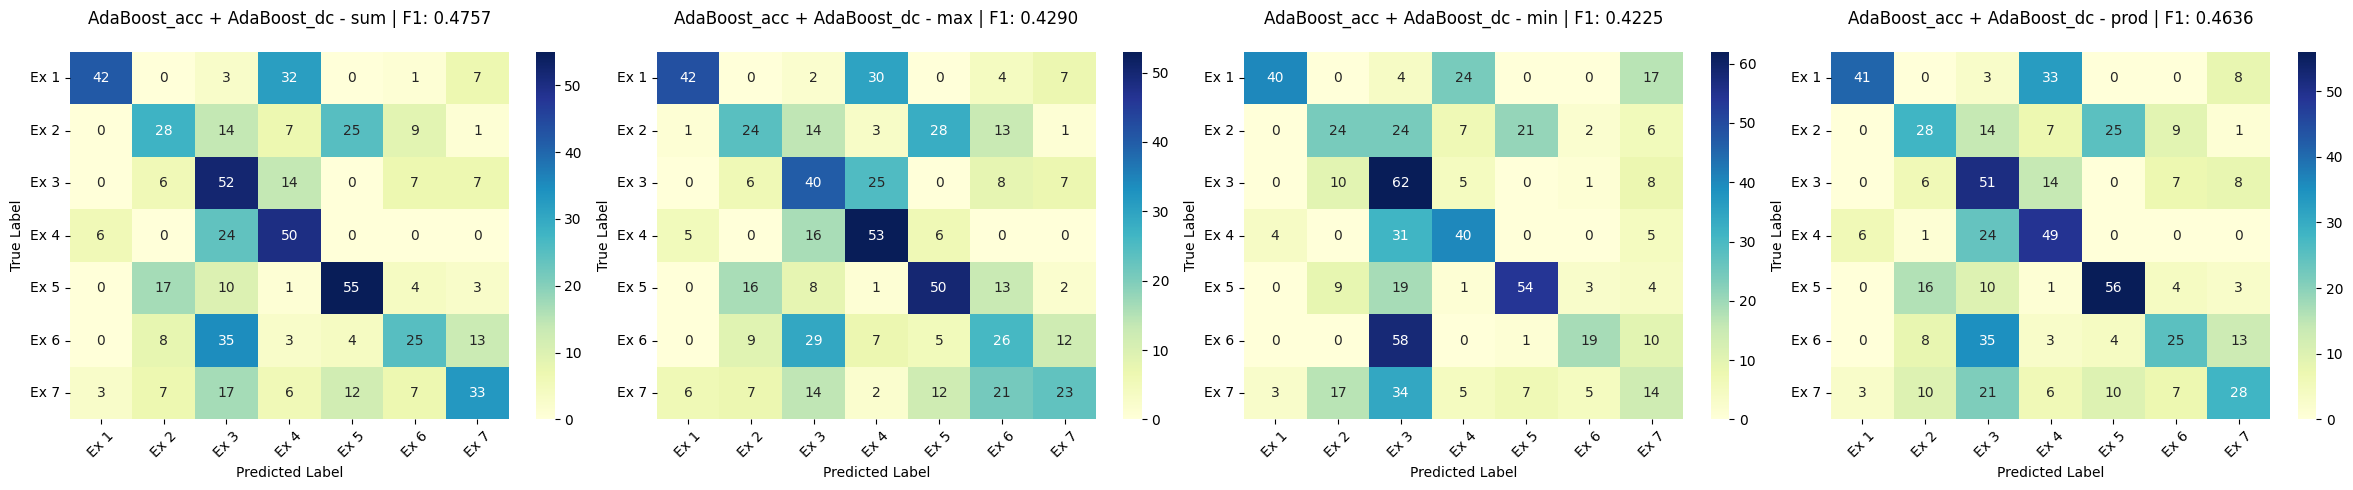


Results for SVM_acc + AdaBoost_dc:


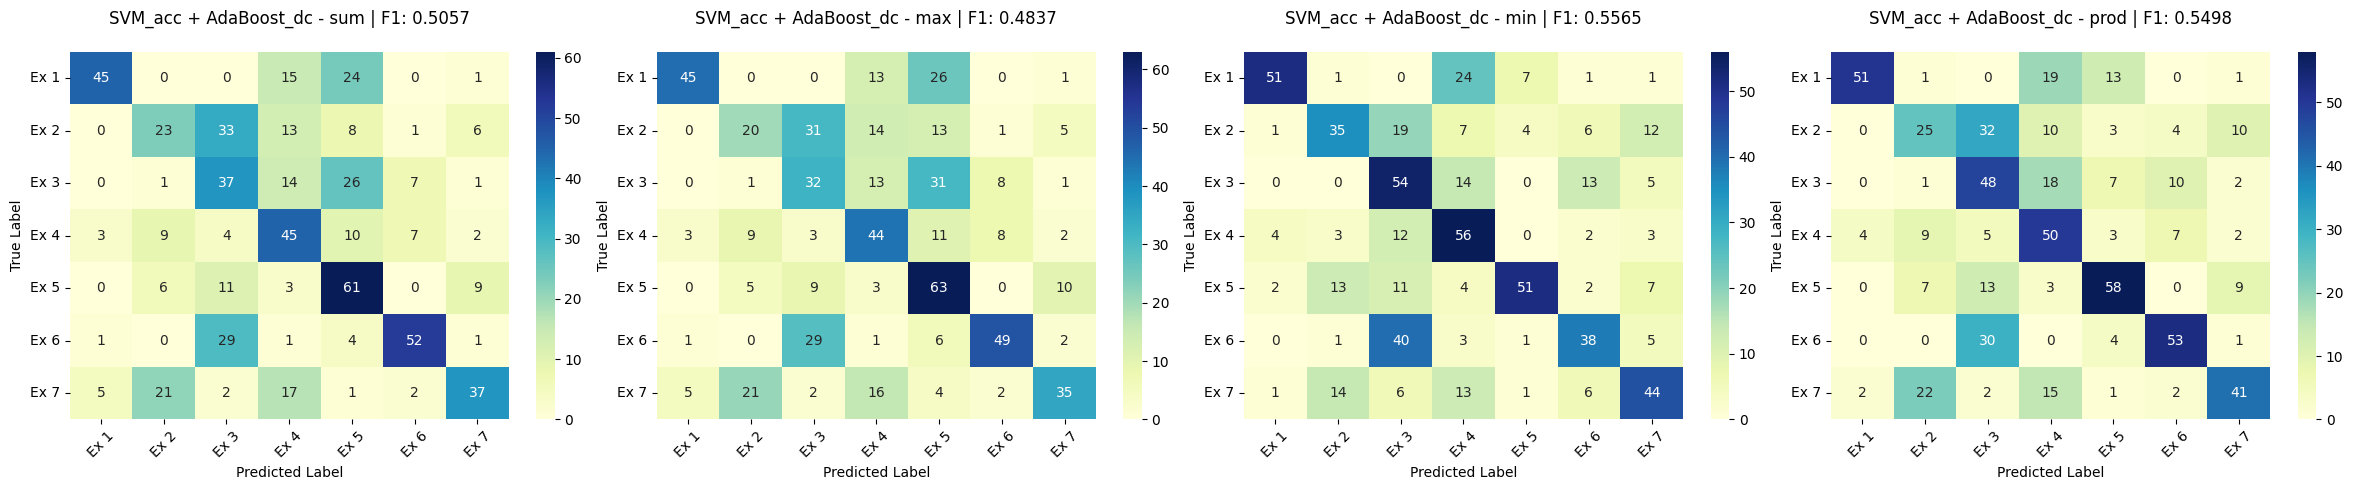


Results for AdaBoost_acc + SVM_dc:


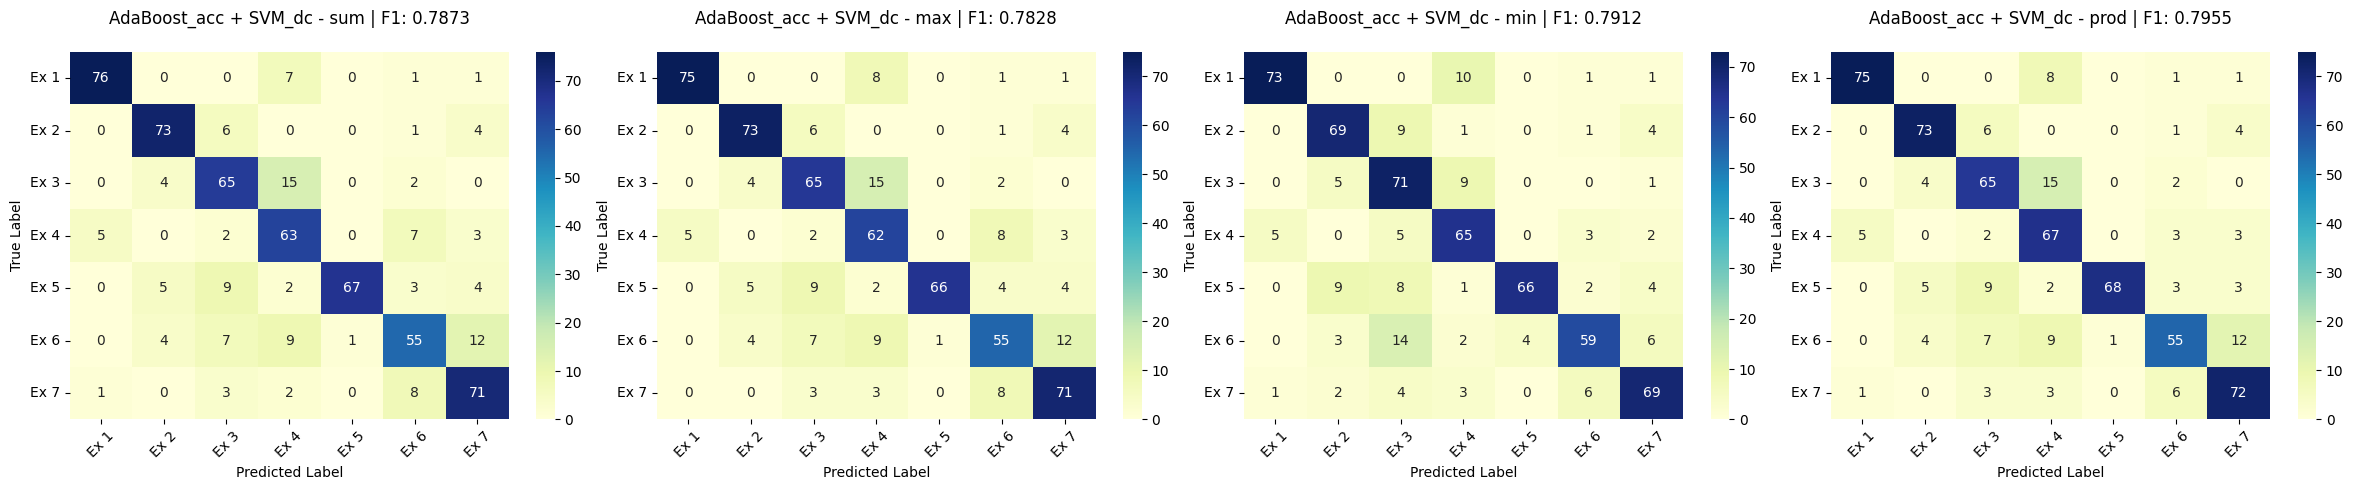

In [13]:
def apply_fusion_rule(probs1, probs2, rule='sum'):
    if rule == 'sum':
        return probs1 + probs2
    elif rule == 'max':
        return np.maximum(probs1, probs2)
    elif rule == 'min':
        return np.minimum(probs1, probs2)
    elif rule == 'prod':
        return probs1 * probs2
    else:
        raise ValueError("Invalid fusion rule")

def evaluate_fusion(probs1, probs2, true_labels, rule='sum', name=''):
    # Apply fusion rule
    fused_probs = apply_fusion_rule(probs1, probs2, rule)
    
    # Get predictions from fused probabilities
    predictions = np.argmax(fused_probs, axis=1)
    
    # Calculate metrics
    f1_fused = f1_score(true_labels, predictions, average='macro')
    conf_mat = confusion_matrix(true_labels, predictions)
    
    return f1_fused, conf_mat, predictions

test_labels_int = test_labels.astype(int) - 1

# Define the fusion rules
fusion_rules = ['sum', 'max', 'min', 'prod']
combinations = [
    ('SVM_acc + SVM_dc', probability_predictions['acc_svm'], probability_predictions['dc_svm']),
    ('AdaBoost_acc + AdaBoost_dc', probability_predictions['acc_adaboost'], probability_predictions['dc_adaboost']),
    ('SVM_acc + AdaBoost_dc', probability_predictions['acc_svm'], probability_predictions['dc_adaboost']),
    ('AdaBoost_acc + SVM_dc', probability_predictions['acc_adaboost'], probability_predictions['dc_svm'])
]

fusion_results = {}
for combo_name, probs1, probs2 in combinations:
    fusion_results[combo_name] = {}
    
    for rule in fusion_rules:
        f1, conf_mat, preds = evaluate_fusion(probs1, probs2, test_labels_int, rule, combo_name)
        fusion_results[combo_name][rule] = {
            'f1': f1,
            'conf_matrix': conf_mat,
            'predictions': preds
        }

for combo_name, rules in fusion_results.items():
    print(f"\nResults for {combo_name}:")
    fig, axes = plt.subplots(1, 4, figsize=(24, 5)) 
    
    for i, (rule, metrics) in enumerate(rules.items()):
        # print(f"{rule}: F1 Score = {metrics['f1']:.4f}")
        cf_title = f"{combo_name} - {rule} | F1: {metrics['f1']:.4f}"
        plot_confusion_matrix(metrics['conf_matrix'], class_names, title=cf_title, ax=axes[i])
    
    plt.tight_layout() 
    plt.show() 


We combined the probabilistic outputs from different modalities and classifiers using fixed fusion rules. The goal was to evaluate and compare the performance of various classifier combinations.

We defined two functions: apply_fusion_rule to apply the fusion rules (sum, max, min, prod) and evaluate_fusion to evaluate the fused predictions and calculate metrics.
We created a list of classifier combinations to evaluate, including SVM_acc + SVM_dc, AdaBoost_acc + AdaBoost_dc, SVM_acc + AdaBoost_dc, and AdaBoost_acc + SVM_dc. For each combination and fusion rule, we applied the fusion, obtained predictions, and calculated the F1 score and confusion matrix. The fusion results were stored in a nested dictionary fusion_results, with the outer keys representing the classifier combinations and the inner keys representing the fusion rules.

Finally, we visualized the confusion matrices for each combination and fusion rule, along with their corresponding F1 scores. This allowed us to compare the performance of different fusion strategies and identify the most effective combination. From the F1 scores and the Confusion Matrices across each combination, the best performing combination was SVM_acc+SVM_dc was a F1 score of 0.8252. 

# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br> 
<br> 
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br> 
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

Training samples - ACC: 493, DC: 493
Testing samples - ACC: 1591, DC: 1591

PCA shapes - ACC train: (493, 30), DC train: (493, 50)
PCA shapes - ACC test: (1591, 30), DC test: (1591, 50)

F1 Score for Person Identification: 0.5383


<Figure size 1000x800 with 0 Axes>

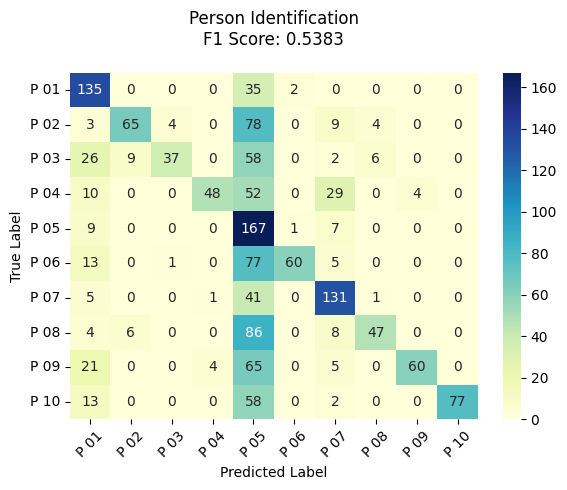

In [14]:
# 5.1

### Your code begins here ###

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score

def split_sequence_train_test(df_records, train_split_ratio=0.25):
    train_records = []
    test_records = []
    
    # First group by subject to ensure all sequences are handled
    for subject_id in sorted(df_records['subject_id'].unique()):
        subject_data = df_records[df_records['subject_id'] == subject_id]
        
        # Then by exercise and trial
        for exercise_id in sorted(subject_data['exercise_id'].unique()):
            exercise_data = subject_data[subject_data['exercise_id'] == exercise_id]
            
            for trial in sorted(exercise_data['trial'].unique()):
                # Get sequence data
                sequence = exercise_data[exercise_data['trial'] == trial]
                
                # Split by modality
                acc_data = sequence[sequence['sensor'] == 'acc']
                dc_data = sequence[sequence['sensor'] == 'dc']
                
                # Find common windows between modalities
                acc_windows = set(acc_data['window_idx'])
                dc_windows = set(dc_data['window_idx'])
                common_windows = sorted(list(acc_windows.intersection(dc_windows)))
                
                
                split_idx = int(len(common_windows) * train_split_ratio)
                train_windows = common_windows[:split_idx]
                test_windows = common_windows[split_idx:]
                
                # Add to appropriate sets
                for sensor_data in [acc_data, dc_data]:
                    train_records.append(sensor_data[sensor_data['window_idx'].isin(train_windows)])
                    test_records.append(sensor_data[sensor_data['window_idx'].isin(test_windows)])
    
    return pd.concat(train_records), pd.concat(test_records)

# Split the data
train_data, test_data = split_sequence_train_test(df_records_windowed)

# Separate and sort modalities
train_data_acc = train_data[train_data['sensor'] == 'acc'].sort_values(['subject_id', 'exercise_id', 'trial', 'window_idx'])
train_data_dc = train_data[train_data['sensor'] == 'dc'].sort_values(['subject_id', 'exercise_id', 'trial', 'window_idx'])
test_data_acc = test_data[test_data['sensor'] == 'acc'].sort_values(['subject_id', 'exercise_id', 'trial', 'window_idx'])
test_data_dc = test_data[test_data['sensor'] == 'dc'].sort_values(['subject_id', 'exercise_id', 'trial', 'window_idx'])

print(f"Training samples - ACC: {len(train_data_acc)}, DC: {len(train_data_dc)}")
print(f"Testing samples - ACC: {len(test_data_acc)}, DC: {len(test_data_dc)}")

# Preprocess and extract features using functions from Task 2
train_data_acc.loc[:, 'df'] = train_data_acc['df'].apply(lambda x: standardize_acc_data(downsample_acc_data(x)))
test_data_acc.loc[:, 'df'] = test_data_acc['df'].apply(lambda x: standardize_acc_data(downsample_acc_data(x)))

train_data_dc.loc[:, 'df'] = train_data_dc['df'].apply(standardize_dc_data)
test_data_dc.loc[:, 'df'] = test_data_dc['df'].apply(standardize_dc_data)

# Extract PCA features (10 components)
pca_acc, pca_acc_train, pca_acc_test = fit_and_project_pca_for_acc(train_data_acc, test_data_acc, 10)
pca_dc, pca_dc_train, pca_dc_test = fit_and_project_pca_for_dc(train_data_dc, test_data_dc, 10)

print(f"\nPCA shapes - ACC train: {pca_acc_train.shape}, DC train: {pca_dc_train.shape}")
print(f"PCA shapes - ACC test: {pca_acc_test.shape}, DC test: {pca_dc_test.shape}")

# Combine features
features_train = np.hstack((pca_acc_train, pca_dc_train))
features_test = np.hstack((pca_acc_test, pca_dc_test))

# Normalize combined features
scaler = MinMaxScaler()
features_train_normalized = scaler.fit_transform(features_train)
features_test_normalized = scaler.transform(features_test)

# Get person IDs as labels
train_labels = train_data_acc['subject_id'].values
test_labels = test_data_acc['subject_id'].values

# Train SVM classifier (parameters from Task 4)
svm = SVC(kernel='rbf', C=10.0, gamma=2.0)
svm.fit(features_train_normalized, train_labels)

# Predictions and evaluation
predictions = svm.predict(features_test_normalized)
f1 = f1_score(test_labels, predictions, average='macro')
conf_mat = confusion_matrix(test_labels, predictions)

print(f"\nF1 Score for Person Identification: {f1:.4f}")
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_mat, 
                     [f"P {i:02d}" for i in range(1, 11)],
                     title=f'Person Identification\nF1 Score: {f1:.4f}')
plt.show()

### Your code ends here ###

Training samples - ACC: 1219, DC: 1219
Testing samples - ACC: 865, DC: 865

PCA shapes - ACC train: (1219, 30), DC train: (1219, 50)
PCA shapes - ACC test: (865, 30), DC test: (865, 50)

F1 Score for Person Identification: 0.7855


<Figure size 1000x800 with 0 Axes>

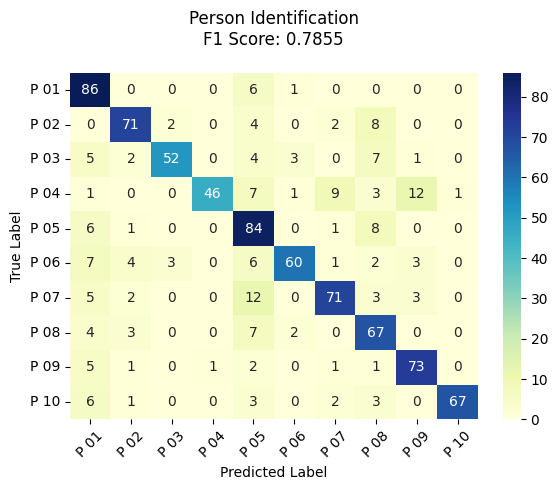

In [15]:
# Split the data based on our own idea and grounds for it!

train_data, test_data = split_sequence_train_test(df_records_windowed, 0.6)

# Separate and sort modalities
train_data_acc = train_data[train_data['sensor'] == 'acc'].sort_values(['subject_id', 'exercise_id', 'trial', 'window_idx'])
train_data_dc = train_data[train_data['sensor'] == 'dc'].sort_values(['subject_id', 'exercise_id', 'trial', 'window_idx'])
test_data_acc = test_data[test_data['sensor'] == 'acc'].sort_values(['subject_id', 'exercise_id', 'trial', 'window_idx'])
test_data_dc = test_data[test_data['sensor'] == 'dc'].sort_values(['subject_id', 'exercise_id', 'trial', 'window_idx'])

print(f"Training samples - ACC: {len(train_data_acc)}, DC: {len(train_data_dc)}")
print(f"Testing samples - ACC: {len(test_data_acc)}, DC: {len(test_data_dc)}")

# Preprocess and extract features using functions from Task 2
train_data_acc.loc[:, 'df'] = train_data_acc['df'].apply(lambda x: standardize_acc_data(downsample_acc_data(x)))
test_data_acc.loc[:, 'df'] = test_data_acc['df'].apply(lambda x: standardize_acc_data(downsample_acc_data(x)))

train_data_dc.loc[:, 'df'] = train_data_dc['df'].apply(standardize_dc_data)
test_data_dc.loc[:, 'df'] = test_data_dc['df'].apply(standardize_dc_data)

# Extract PCA features (10 components)
pca_acc, pca_acc_train, pca_acc_test = fit_and_project_pca_for_acc(train_data_acc, test_data_acc, 10)
pca_dc, pca_dc_train, pca_dc_test = fit_and_project_pca_for_dc(train_data_dc, test_data_dc, 10)

print(f"\nPCA shapes - ACC train: {pca_acc_train.shape}, DC train: {pca_dc_train.shape}")
print(f"PCA shapes - ACC test: {pca_acc_test.shape}, DC test: {pca_dc_test.shape}")

# Combine features
features_train = np.hstack((pca_acc_train, pca_dc_train))
features_test = np.hstack((pca_acc_test, pca_dc_test))

# Normalize combined features
scaler = MinMaxScaler()
features_train_normalized = scaler.fit_transform(features_train)
features_test_normalized = scaler.transform(features_test)

# Get person IDs as labels
train_labels = train_data_acc['subject_id'].values
test_labels = test_data_acc['subject_id'].values

# Train SVM classifier (parameters from Task 4)
svm = SVC(kernel='rbf', C=10.0, gamma=2.0)
svm.fit(features_train_normalized, train_labels)

# Predictions and evaluation
predictions = svm.predict(features_test_normalized)
f1 = f1_score(test_labels, predictions, average='macro')
conf_mat = confusion_matrix(test_labels, predictions)

print(f"\nF1 Score for Person Identification: {f1:.4f}")
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_mat, 
                     [f"P {i:02d}" for i in range(1, 11)],
                     title=f'Person Identification\nF1 Score: {f1:.4f}')
plt.show()

It was specified in the task 5 to use the first 25% of each exercise sequence for training and the remaining 75% for testing. However, when we followed this approach, we observed a significant misclassification for Person 5, and the overall F1 score was relatively low at 0.53.

To address this issue, we experimented some different ideas such as , adjusting the train-test split ratio. We found that by increasing the proportion of data used for training, we could improve the classifier's performance. Specifically, when we used 60% of the data for training and 40% for testing, we observed a notable reduction in misclassifications and an increase in the F1 score to 0.7855. Our reasoning behind this adjustment is that having more training data allows the classifier to learn more robust and generalizable patterns for each person. also the original split of 25% for training and 75% for testing may not provide enough diverse examples for the classifier to learn from, especially considering the limited number of subjects (10) in the dataset. there should be still some problems to explore maybe we will do it later. 

we used the same preprocessing steps and feature extraction techniques as in the previous tasks. We applied PCA with 10 components to both the accelerometer and depth camera data and combined the features using horizontal stacking. We then normalized the combined features using the MinMaxScaler.For the classification model, we utilized the SVM classifier with the RBF kernel and the hyperparameters (C=10.0 and gamma=2.0) that were found to be effective in Task.

The resulting confusion matrix with the 60-40 split shows a more balanced classification across all persons, with fewer misclassifications compared to the original split. 


Thank you for the opportunity to work on this project. It was a valuable learning experience!


<a id='task5'></a>
<div class=" alert alert-warning">

<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [16]:
# 5.2

### Your code begins here ###

### Your code ends here ###